In [ ]:
#----------------------------
#Section 1: Semicircle System
#----------------------------

In [1]:
import numpy as np
import newt.glib as glb
import newt.glibShapes as gshp
import newt.pg2Multi as p2m
import matplotlib.pyplot as plt
import newt.multipoleLib as mplb
import newt.qlm as qlm
import newt.translations as trns
import newt.rotations as rots
import matplotlib.pyplot as plt

#constants used

DENSITY = 2700 #aluminum density

#code-specific values
N = 300
n = 8

#values for main part of device
INCH = 0.1016/4
THICK = 0.003175/2 #1/16 in
OUTER_RAD = 1.65*INCH #now 2in #4in
INNER_RAD = OUTER_RAD - THICK #now 1 & 15/16 in #3 & 15/16in #can change to make thicker & easier to machine
HEIGHTPEROUTERRAD = np.pi/2 
HEIGHT = HEIGHTPEROUTERRAD*OUTER_RAD #now pi in #2pi in, found to minimize 20 moment for other values

mpercent1 = 0.00010508056905373423*4
mpercent2 = 0.00011365919189217833*4
mpercent3 = 2.652047810817494*10**(-5)*4

#values for grippy parts
GRIP_ON = False #if we want "grips" (maybe springs on outside), something for the science pendulum to rest on)
GRIP_RADIUS = 2*0.0127 #1 in

In [2]:
#helper functions

#both rotates and translates a mass object, can use either-or or both
def rotate_trans(mass_object, rotation = 0, translation = [0, 0, 0], axis = [0, 0, 1]):
    return glb.translate_point_array(glb.rotate_point_array(mass_object, rotation, axis), translation)

#rotate_trans for qlm
def rotate_transqlm(qlm, rotation = 0, translation = [0, 0, 0], axis = [0, 0, 1]):
    return trns.translate_qlm(rots.rotate_qlm(qlm, rotation*axis[0], rotation*axis[1], rotation*axis[2]), translation)

#gets mass of shifted circle bit
def mass_circle(thick = THICK, orad = OUTER_RAD, irad = INNER_RAD):
    return DENSITY*thick*np.pi/2*(orad**2-irad**2)

#gets mass of beams linking circles
def mass_beam(thick = THICK, h = HEIGHT):
    return DENSITY*thick**2*h

#gets mass of the grips
def get_a_grip(thick = THICK, rad = INNER_RAD, griprad = GRIP_RADIUS):
    return DENSITY*thick**2*griprad

#gets 00 (in grams), 2i moments of a mass distrib
def get_moments(totalm):
    return [p2m.qmoment(0, 0, totalm)*1000, p2m.qmoment(2, 0, totalm), p2m.qmoment(2, 1, totalm), p2m.qmoment(2, 2, totalm)]

#prints moments 00, 2i
def print_moments(totalm):
    for i in range(4):
        if i == 0:
            strin = "mass [g]"
        else:
            strin = "2"+str(i-1)+" moment"
        print(get_moments(totalm)[i], strin)

In [3]:
#masses for standard body
MASS_SHIFTED_CIRCLE = mass_circle()
MASS_BEAM = mass_beam()
MASS_GRIP_INNER = get_a_grip(rad = INNER_RAD)
MASS_GRIP_OUTER = get_a_grip(rad = OUTER_RAD)

In [4]:
#function to get shape
#need to re-run every time one of the params is changed
def get_gradiometer(thick = THICK, outer = OUTER_RAD, height = HEIGHT, inner = INNER_RAD, N = N, n = n, grip_rad = GRIP_RADIUS):
    #combines two semicircles into one mass object, semicircles at +- OUTER_RAD/2
    wedge = gshp.wedge(mass_circle(thick, outer, inner), inner, outer, thick, np.pi/2, int(N/5), n*2)
    wedge1shifted = rotate_trans(wedge, translation=[0, 0, -height/2])
    wedge2shifted = rotate_trans(wedge, np.pi, [0, 0, height/2])
    wedgescombined = np.concatenate([wedge1shifted, wedge2shifted])

    #combines two edges connecting semicircles into one mass object
    beam = gshp.rectangle(mass_beam(thick, height), thick, thick, height, int(N/20), int(N/20), n*2)
    beam1shifted = rotate_trans(beam, translation=[0, inner, 0])
    beam2shifted = rotate_trans(beam, translation=[0, -inner, 0])
    beamscombined = np.concatenate([beam1shifted, beam2shifted])
    #beamscombined = rotate_trans(beamscombined, translation = [0, 0, height/2])

    #creates middle "sinusoidal" section, cut out section points OOP & "rightward"
    frust = rotate_trans(gshp.outer_cone(mpercent1, 0.00523494, 0.00680974, 0.00161036, np.pi/2, n*8, n*6))
    frust = rotate_trans(frust, rotation = -np.pi/2, axis = [0, 1, 0])
    frust = rotate_trans(frust, translation = [0.0200279, 0, 0])
    f1 = rotate_trans(frust, rotation = np.pi/2)
    f2 = rotate_trans(frust, rotation = np.pi)
    f3 = rotate_trans(frust, rotation = 3*np.pi/2)
    ftot = np.concatenate([frust, f1, f2, f3])
    #-------------------------------------------------------------------------------------
    enc = gshp.wedge(mpercent2, 0.0200279, 0.02163572, 0.001651, np.pi/7, n*8, n*2)
    enc = rotate_trans(enc, rotation = np.pi/4)
    enc1 = rotate_trans(enc, rotation = np.pi/2)
    enc2 = rotate_trans(enc1, rotation = np.pi/2)
    enclast1 = gshp.wedge(mpercent3, 0.0200279, 0.02163572, 0.001651, np.pi/30, n*8, n*2)
    enclast1 = rotate_trans(enclast1, -np.pi/4+np.pi/10)
    enclast2 = rotate_trans(enclast1, -2*np.pi/10)
    enctot = np.concatenate([enc, enc1, enc2, enclast1, enclast2])
    sinpart = rotate_trans(np.concatenate([ftot, enctot]), np.pi/4)
    
    #creates bar joining sinusoid to beams
    bar = gshp.rectangle(thick*thick*(inner-0.02163572), thick, inner-0.02163572, thick, int(n*3), int(n*3), int(n*3))
    bar1 = rotate_trans(bar, translation = [0, (inner-0.02163572)/2+0.02163572, 0])
    bar2 = rotate_trans(bar1, rotation = np.pi)
    bartot = np.concatenate([bar1, bar2])
    
    #does some concatenating to be able to move the inner part up/down to get CoM at the center of pendulum
    barwithsin = np.concatenate([sinpart, bartot])
    barwithsin = rotate_trans(barwithsin, translation = [0, 0, 0.0418084-height/2+thick/2]) #1.646in is good height for 21
    beamscombined = np.concatenate([barwithsin, beamscombined])
    
    #creates the grips at the top of the apparatus to have it be put on the science pendulum
    #was an old attempt for grips, newer style works better
    if GRIP_ON:
        gripheight = height/2-thick
        gripxyin = inner-grip_rad/4
        gripxyout = outer+grip_rad/4
        
        gripinner = gshp.rectangle(get_a_grip(thick, inner, grip_rad), thick, grip_rad, thick, int(N/20), int(N/20), n)
        griptli = rotate_trans(gripinner, translation = [0, gripxyin, gripheight])
        griptri = rotate_trans(gripinner, translation = [0, -gripxyin, gripheight])
        gripbli = rotate_trans(gripinner, translation = [0, gripxyin, -gripheight])
        gripbri = rotate_trans(gripinner, translation = [0, -gripxyin, -gripheight])
        
        gripouter = gshp.rectangle(get_a_grip(thick, outer, grip_rad), thick, grip_rad, thick, int(N/20), int(N/20), n)
        griptlo = rotate_trans(gripinner, translation = [0, gripxyout, gripheight])
        griptro = rotate_trans(gripinner, translation = [0, -gripxyout, gripheight])
        gripblo = rotate_trans(gripinner, translation = [0, gripxyout, -gripheight])
        gripbro = rotate_trans(gripinner, translation = [0, -gripxyout, -gripheight])
        
        beamgripcombined = np.concatenate([beam1shifted, beam2shifted, griptli, griptri, gripbli, gripbri, griptlo, griptro, gripblo, gripbro])
    
    else:
        beamgripcombined = beamscombined
    
    return [wedgescombined, beamgripcombined]

In [5]:
def get_rotator():
    cylmass = gshp.wedge(1.24, 0, INCH, 3.85*INCH, np.pi, 4*n, 2*n)
    cylmass1 = rotate_trans(cylmass, translation = [INCH, 0, 3.85*INCH/2+INCH*.85/2])
    cylmass2 = rotate_trans(cylmass, translation = [-INCH, 0, 3.85*INCH/2+INCH*.85/2])
    basecyl = gshp.wedge(1.095, 0, INCH*2, INCH*.85, np.pi, 3*n, n*2)
    testmasses = np.concatenate([cylmass1, cylmass2, basecyl])
    leftside = rotate_trans(testmasses, translation = [INCH*4.5, 0, 0])
    rightside = rotate_trans(testmasses, translation = [-INCH*4.5, 0, 0])
    totaltestmass = np.concatenate([leftside, rightside])
    totaltestmass = rotate_trans(totaltestmass, translation = [0, 0, INCH*.275/2])
    baserect = gshp.rectangle(INCH**3*13*2*.275*DENSITY, INCH*13, 2*INCH, INCH*.275, 4*n, n*2, n)
    baserect = rotate_trans(baserect, translation = [0, INCH, 0])
    totalrotator = np.concatenate([baserect, totaltestmass])
    return [baserect, totaltestmass]

In [8]:
rotation_vector = [0, 13.625*INCH, 3.5*INCH]
neg_rotation_vector = [0, -13.625*INCH, -3.5*INCH]
rotator = np.concatenate([get_rotator()[0], get_rotator()[1]])
grad = np.concatenate([get_gradiometer()[0], get_gradiometer()[1]])
rotator = rotate_trans(rotator, rotation = np.pi/2)
rotator = rotate_trans(rotator, translation = rotation_vector)

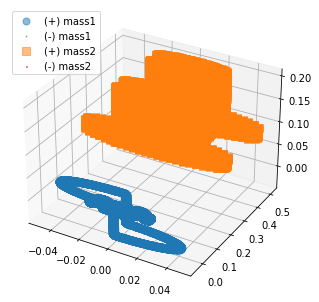

In [7]:
fig, ax = glb.display_points(grad, rotator)

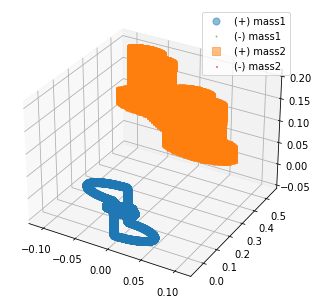

In [13]:
rotator = rotate_trans(rotator, translation = neg_rotation_vector)
rotator = rotate_trans(rotator, rotation = np.pi*1/6)
rotator = rotate_trans(rotator, translation = rotation_vector)
#print(p2m.Qmomentsb(4, rotator)[2, 5])
fig, ax = glb.display_points(grad, rotator)

In [21]:
gradmoments = p2m.qmoments(4, grad)
rotatormoments = p2m.Qmomentsb(4, rotator)

In [354]:
rotatormoments[2, 5]

(7.282369152150636e-15-41.71012577243084j)

In [34]:
nlm, nc, ns = mplb.torque_lm(4, gradmoments, rotatormoments)

In [9]:
nlms = []
ncs = []
nss = []
Q21 = []
for i in range(180):
    rotator = rotate_trans(rotator, translation = neg_rotation_vector)
    rotator = rotate_trans(rotator, rotation = np.pi/90)
    rotator = rotate_trans(rotator, translation = rotation_vector)
    rotatormoments = p2m.Qmomentsb(4, rotator)
    Q21.append(rotatormoments[2, 5])
    gradmoments = p2m.qmoments(4, grad)
    m, c, s = mplb.torque_lm(4, gradmoments, rotatormoments)
    nlms.append(m)
    ncs.append(c)
    nss.append(s)

In [10]:
nlms = np.array(nlms)
ncs = np.array(ncs)
nss = np.array(nss)

In [343]:
nlms[0, 2]

array([0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
       3.59868460e-16-1.69270076e-14j, 1.46963794e-14+1.86108054e-16j,
       0.00000000e+00-0.00000000e+00j, 1.46963794e-14-1.86108054e-16j,
       3.59868460e-16+1.69270076e-14j, 0.00000000e+00+0.00000000e+00j,
       0.00000000e+00+0.00000000e+00j])

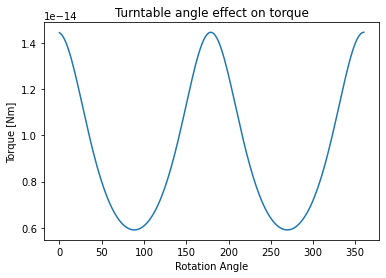

In [11]:
plt.plot(np.linspace(0, 360, 180), np.real(nlms[:, 2, 5]))
plt.xlabel("Rotation Angle")
plt.ylabel("Torque [Nm]")
plt.title("Turntable angle effect on torque")
plt.show()

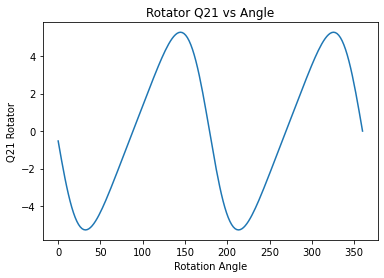

In [12]:
plt.plot(np.linspace(0, 360, 180), np.real(Q21))
plt.xlabel("Rotation Angle")
plt.ylabel("Q21 Rotator")
plt.title("Rotator Q21 vs Angle")
plt.show()

(-0.0425, 0.0425)

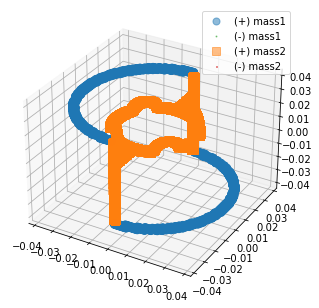

In [26]:
#trying to create shape from autocad
mass_distrib = get_gradiometer()
fig, ax = glb.display_points(mass_distrib[0], mass_distrib[1])
ax.set_zlim([-.17/4, .17/4])

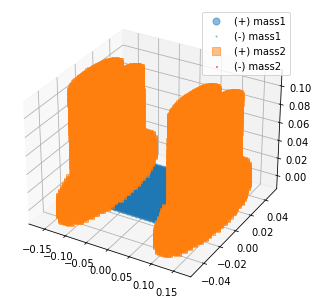

In [289]:
rotator_distrib = get_rotator()
fig, ax = glb.display_points(rotate_trans(rotator_distrib[0], rotation = 0), rotate_trans(rotator_distrib[1], rotation = 0))

(-0.085, 0.085)

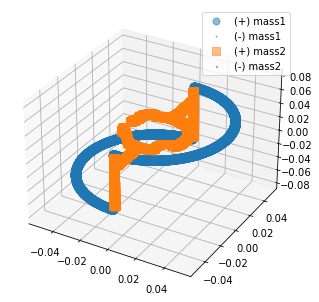

In [7]:
mass_distrib_rotated = [rotate_trans(get_gradiometer()[0], rotation = np.pi), rotate_trans(get_gradiometer()[1], rotation = np.pi)]
fig, ax = glb.display_points(mass_distrib_rotated[0], mass_distrib_rotated[1])
ax.set_zlim([-.17/2, .17/2])

In [8]:
#calculating moments of standard body

totalmass = np.concatenate(mass_distrib)
standardmoments = get_moments(totalmass)
print_moments(totalmass)

1.8242798059025107 mass [g]
(-4.304203743097495e-07+0j) 20 moment
(2.1028295004728408e-06+4.367513634279986e-22j) 21 moment
(-1.0122202703485503e-06-2.150233384111721e-22j) 22 moment


In [25]:
totalmass = np.concatenate(mass_distrib)
#p2m.qmoment(2, 1, totalmass)
for i in range(10):
    for j in range(2*i+1):
        momenij = p2m.qmoment(i, j-i, totalmass)
        if abs(momenij) >= 10**(-8) and j >= i:
            print("Moment "+str(i)+str(j-i)+": "+str(abs(momenij)))

Moment 00: 0.0018242798059025112
Moment 10: 8.179922368834134e-06
Moment 11: 1.7151054767417163e-06
Moment 20: 4.2876069813215903e-07
Moment 21: 2.0794151541719613e-06
Moment 22: 1.0428938047202511e-06
Moment 40: 1.3331811602221279e-08


In [42]:
#varying parameters to find optimal moment

ran = 10
#small variations (inc = increment)
def incl(l, mag = 1):
    return [l*(1+mag*(i-ran/2)) for i in range(ran)]
HEIGHTINC = incl(HEIGHT, .0001)
OUTERRADINC = incl(OUTER_RAD, .001)

In [49]:
#looking at height inc

momentsheight00 = []
momentsheight20 = []
momentsheight21 = []
momentsheight22 = []
for i in range(len(HEIGHTINC)):
    gradobjectheightinc = get_gradiometer(height = HEIGHTINC[i])
    totalmass = np.concatenate(gradobjectheightinc)
    standardmoments = get_moments(totalmass)
    momentsheight00.append(standardmoments[0])
    momentsheight20.append(standardmoments[1])
    momentsheight21.append(standardmoments[2])
    momentsheight22.append(standardmoments[3])

C:\Users\turnb\Documents\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


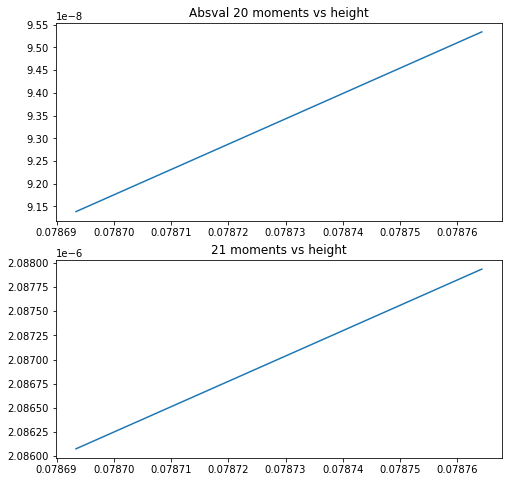

In [52]:
#plotting height increments against the produced moments

fig, axs = plt.subplots(2, 1, figsize=(8, 8))
axs[0].plot(HEIGHTINC, np.abs(momentsheight20))
axs[0].set_title("Absval 20 moments vs height")
axs[1].plot(HEIGHTINC, momentsheight21)
axs[1].set_title("21 moments vs height")
#axs[2].plot(HEIGHTINC, np.abs(momentsheight22))
#axs[2].set_title("Absval 22 moments vs height")
plt.show()

In [52]:
#finding height where 20 moment is roughly 0
#np.where(momentsheight20 == np.min(np.abs(momentsheight20)))
#momentsheight20[5] #check to see if it is the min of the abs
#HEIGHTINC[5], HEIGHT
#momentsheight21[4]

In [ ]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#TAKES A LONG TIME TO RUN, DON'T ACCIDENTALLY RUN
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

#looking at both height and radius increments
momentsinc = []
for i in range(len(OUTERRADINC)):
    momentplace = []
    for j in range(len(HEIGHTINC)):
        gradobjectcompinc = get_gradiometer(rad = OUTERRADINC[i], height = HEIGHTINC[j])
        totalmass = np.concatenate(gradobjectcompinc)
        standardmoments = get_moments(totalmass)
        momentplace.append(standardmoments)
        #printing will cause the output to be massive
        #print(standardmoments)
        
    momentinc.append(momentplace)

In [ ]:
#--------------------------
#Section 2: Two-Mass System
#--------------------------

#NOTE
#The two-mass system has been dropped at the semicircle system seems to work better in lab

In [10]:
#rougly 5.8g
#standardmoments[0]-standardmomentstwo[0] if standardmomentstwo[0] is not None else 5.8
LEFTOVERMASS = 5.8/1000

In [11]:
#mass of the main section of the x-axial wire
def mass_main_wire(thick = THICK, outer = OUTER_RAD):
    return DENSITY*thick**2*(outer-4*thick)

#mass of the wire connecting the mass at 0 to the main wire
def mass_vertical_wire(thick = THICK, height = HEIGHT):
    return DENSITY*thick**2*height

#mass of the circular part
def mass_circle_part(thick = THICK):
    return DENSITY*3*np.pi/4*thick**3

#mass of the "grips" of this system
def mass_grip_two(thick = THICK, grip_rad = GRIP_RADIUS):
    return DENSITY*grip_rad*thick**2

In [56]:
def get_twomass(thick = THICK, outer = OUTER_RAD, height = HEIGHT, inner = INNER_RAD, N = N, n = n, grip_rad = GRIP_RADIUS):
    #makes the horizontal part of the wire
    mainwire = gshp.rectangle(mass_main_wire(thick, outer), outer-4*thick, thick, thick, int(N), n, n)
    mainwireleft = rotate_trans(mainwire, translation = [(outer-4*thick)/2, 2*thick, height+thick/2])
    mainwireright = rotate_trans(mainwire, translation = [(outer-4*thick)/2, -2*thick, height+thick/2])
    
    #makes the vertical part of the wire
    verticalwire = gshp.rectangle(mass_vertical_wire(thick, height), thick, thick, height, n, n, int(N/20))
    verticalwireshifted = rotate_trans(verticalwire, translation = [2*thick, 0, height/2])
    
    #makes the circle part on the inside of the horizontal wire
    circlepart = gshp.wedge(mass_circle_part(thick), 1.5*thick, 2*thick, thick, 3*np.pi/4, N, n)
    circlepartshifted = rotate_trans(circlepart, rotation = 1/2*np.pi/4, translation = [0, 0, height])
    
    #makes the "grips" of this system
    griptwomass = gshp.rectangle(mass_grip_two(thick, grip_rad), thick, grip_rad, thick, n, int(N/20), n)
    griptwo1 = rotate_trans(griptwomass, translation = [0, grip_rad/2+1.5*thick, height])
    griptwo2 = rotate_trans(griptwomass, translation = [0, -grip_rad/2-1.5*thick, height])
    part2 = np.concatenate([verticalwireshifted, circlepartshifted, griptwo1, griptwo2])
    
    #leftover mass formed into spheres
    leftoverspheres = gshp.sphere(1.8*LEFTOVERMASS, (3/(4*np.pi*DENSITY)*1.8*LEFTOVERMASS)**(1/3), int(N/20))
    sphere1 = rotate_trans(leftoverspheres, translation = [-2*outer+10*thick, 0, height+2*thick])
    sphere2 = rotate_trans(leftoverspheres, translation = [outer/2+3*thick, -2*thick, 0])
    part1 = np.concatenate([mainwireleft, mainwireright, sphere1, sphere2])
    
    return [np.concatenate([circlepartshifted]), part2]
    #return [part1, part2]

(0.0, 0.12)

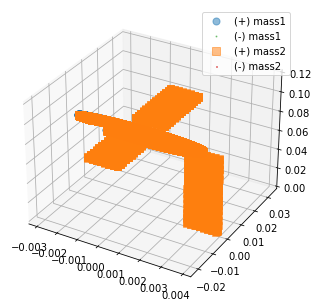

In [57]:
mass_dist_two = get_twomass(height = HEIGHT)
fig, ax = glb.display_points(mass_dist_two[0], mass_dist_two[1])
ax.set_zlim([0, .12])

(-0.17, 0.17)

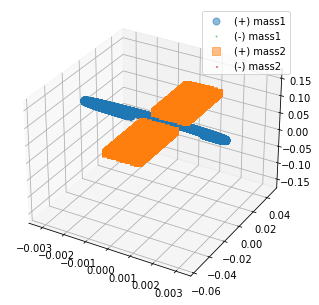

In [43]:
mass_dist_two_rotated = [rotate_trans(get_twomass(height = HEIGHT)[0], rotation = np.pi/2), rotate_trans(get_twomass(height = HEIGHT)[1], rotation = np.pi/2)]

fig, ax = glb.display_points(mass_dist_two_rotated[0], mass_dist_two_rotated[1])
ax.set_zlim([-.17, .17])

In [10]:
#calculating moments of standard second body

totalmasstwo = np.concatenate(mass_dist_two)
standardmomentstwo = get_moments(totalm = totalmasstwo)
print_moments(totalmasstwo)

8.91177626433843 mass [g]
(0.0001582077608814042+0j) 20 moment
(0.00027361173205299954+6.96969189882355e-08j) 21 moment
(0.00015150806632903955+2.3588198654494528e-06j) 22 moment


In [364]:
#looking at height inc for the second object
ran = 10
HEIGHTINCTWO = incl(HEIGHT, .1)

momentsheighttwo00 = []
momentsheighttwo20 = []
momentsheighttwo21 = []
for i in range(len(HEIGHTINCTWO)):
    twomassobjectheightinc = get_twomass(height = HEIGHTINCTWO[i])
    totalmasstwo = np.concatenate(twomassobjectheightinc)
    standardmomentstwo = get_moments(totalmasstwo)
    momentsheighttwo00.append(standardmoments[0])
    momentsheighttwo20.append(standardmoments[1])
    momentsheighttwo21.append(standardmoments[2])

C:\Users\turnb\Documents\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


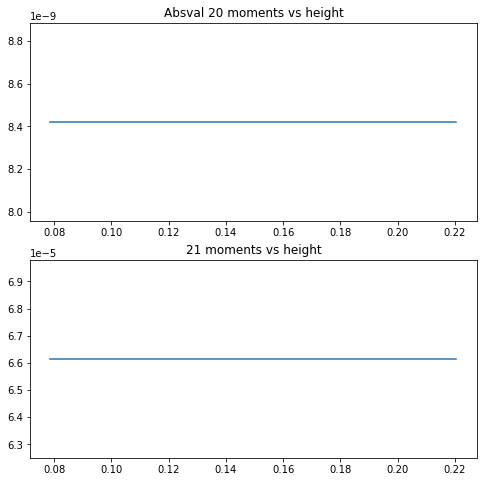

In [367]:
#plotting height increments against the produced moments

fig, axs = plt.subplots(2, 1, figsize=(8, 8))
axs[0].plot(HEIGHTINCTWO, np.abs(momentsheighttwo20))
axs[0].set_title("Absval 20 moments vs height")
axs[1].plot(HEIGHTINCTWO, momentsheighttwo21)
axs[1].set_title("21 moments vs height")
plt.show()

In [ ]:
#----------------------------------------
#Section 3: Outdated Calculations & Tests
#----------------------------------------

In [ ]:
#ignore
#M_FACTOR = 1 #ignore for now
#MASS_LEFTOVER = int((1-M_FACTOR)*TOTAL_MASS) #ignore for now

In [ ]:
#functions that are useful
#wedge(mass, r1, r2, thickness, half angle, nxy, nz)
#rectangle(mass, x, y, z, nx, ny, nz)

In [ ]:
def make_small(l, mag = 1):
    return [l/(i+mag) for i in range(ran)]
def make_large(l, mag = 1):
    return [l*(i+mag) for i in range(ran)]
#can probably ignore these, variation is quite large

HEIGHTSMALL = make_small(HEIGHT)#lowers Q21
HEIGHTLARGE = make_large(HEIGHT)#raises Q21
OUTERRADSMALL = make_small(OUTER_RAD)
OUTERRADLARGE = make_large(OUTER_RAD)

In [ ]:
#mostly ineffective for actually computing moments as the heights either increase or decrease greatly
#outdated

#decreasing height on a large scale
for i in HEIGHTSMALL:
    gradobjectheightinc = get_gradiometer(height = i)

In [ ]:
#looking at radius increments

momentsrad21 = []
for i in range(len(OUTERRADINC)):
    get_gradiometer(outer = OUTERRADINC[i])
    totalmass = np.concatenate(gradobjectheightinc)
    standardmoments = get_moments(totalmass)
    momentsrad21.append(standardmoments[2])

In [ ]:
#looking at radius increments vs moments

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(OUTERRADINC, momentsrad21)
plt.show()

In [ ]:
#looking at relation between varying height and radius for moments

momentarr = np.array(momentinc) #[j, :] is for changing height with rad j, [:, i] is for changing radius with height i 

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].plot(momentarr[:, 0], momentarr[0, :]) #plot of moment from changing radius vs moment from changing height
axs[0, 0].set_title("21 moments of radius vs height")
axs[0, 0].set_xlabel('Moment from changing radius [kg/m^2]')
axs[0, 0].set_ylabel('Moment from changing height [kg/m^2]')
axs[0, 1].plot(HEIGHTINC, momentarr[49, :]) #height changing plot
axs[0, 1].set_title("Radius vs 21 moments")
axs[0, 1].set_xlabel('Changing height [m]')
axs[0, 1].set_ylabel('Moment from changing height [kg/m^2]')
axs[1, 0].plot(OUTERRADINC, momentarr[:, 49]) #radius changing plot
axs[1, 0].set_title("Height vs 21 moments")
axs[1, 0].set_xlabel('Changing radius [m]')
axs[1, 0].set_ylabel('Moment from changing radius [kg/m^2]')
axs[1, 1].plot(OUTERRADINC, HEIGHTINC) #checking radius vs height
axs[1, 1].set_title("Radius vs height")
axs[1, 1].set_xlabel('Changing radius [m]')
axs[1, 1].set_ylabel('Changing height [m]')

slope = np.polyfit(momentarr[:, 0], momentarr[0, :], 2)
X_ = np.linspace(momentarr[:, 0].min(), momentarr[:, 0].max(), 500)
axs[0, 0].plot(X_, slope[0]*X_**2 + slope[1]*X_+slope[2])
plt.show()
print(slope)

In [ ]:
#outdated
#momentcompinc[1][1][2][3] #momentcompinc[rad][height][2 = 2nd moment][2 = 20, 3 = 21, 4 = 22]

#defines lists for the moments of 20, 21, and 22; can be used in same way as momentinc was in previous cell
momentcomp20 = [[momentcompinc[j][i][2][2] for i in range(ran)] for j in range(ran)]
momentcomp21 = [[momentcompinc[j][i][2][3] for i in range(ran)] for j in range(ran)]
momentcomp22 = [[momentcompinc[j][i][2][4] for i in range(ran)] for j in range(ran)]

In [ ]:
#looking at relation between varying height and radius for 20 moments

moment20arr = np.array(momentcomp20) #[j, :] is for changing height with rad j, [:, i] is for changing radius with height i 

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].plot(moment20arr[:, 0], moment20arr[0, :]) #plot of moment from changing radius vs moment from changing height
axs[0, 0].set_title("20 moments of radius vs height")
axs[0, 0].set_xlabel('Moment from changing radius [kg/m^2]')
axs[0, 0].set_ylabel('Moment from changing height [kg/m^2]')
axs[0, 1].plot(HEIGHTINC, moment20arr[49, :]) #height changing plot
axs[0, 1].set_title("Radius vs 20 moments")
axs[0, 1].set_xlabel('Changing height [m]')
axs[0, 1].set_ylabel('Moment from changing height [kg/m^2]')
axs[1, 0].plot(OUTERRADINC, moment20arr[:, 49]) #radius changing plot
axs[1, 0].set_title("Height vs 20 moments")
axs[1, 0].set_xlabel('Changing radius [m]')
axs[1, 0].set_ylabel('Moment from changing radius [kg/m^2]')
axs[1, 1].plot(OUTERRADINC, HEIGHTINC) #checking radius vs height
axs[1, 1].set_title("Radius vs height")
axs[1, 1].set_xlabel('Changing radius [m]')
axs[1, 1].set_ylabel('Changing height [m]')

plt.show()

In [ ]:
#looking at relation between varying height and radius for 20 moments

moment22arr = np.array(momentcomp22) #[j, :] is for changing height with rad j, [:, i] is for changing radius with height i 

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].plot(moment22arr[:, 0], moment22arr[0, :]) #plot of moment from changing radius vs moment from changing height
axs[0, 0].set_title("22 moments of radius vs height")
axs[0, 0].set_xlabel('Moment from changing radius [kg/m^2]')
axs[0, 0].set_ylabel('Moment from changing height [kg/m^2]')
axs[0, 1].plot(HEIGHTINC, moment22arr[49, :]) #height changing plot
axs[0, 1].set_title("Radius vs 22 moments")
axs[0, 1].set_xlabel('Changing height [m]')
axs[0, 1].set_ylabel('Moment from changing height [kg/m^2]')
axs[1, 0].plot(OUTERRADINC, -1*moment22arr[:, 49]) #radius changing plot
axs[1, 0].set_title("Height vs 22 moments")
axs[1, 0].set_xlabel('Changing radius [m]')
axs[1, 0].set_ylabel('(-)Moment from changing radius [kg/m^2]')
axs[1, 1].plot(OUTERRADINC, HEIGHTINC) #checking radius vs height
axs[1, 1].set_title("Radius vs height")
axs[1, 1].set_xlabel('Changing radius [m]')
axs[1, 1].set_ylabel('Changing height [m]')

plt.show()

In [ ]:
#looking at the multipole between two points -- should be simple to make conclusions from

#rectangle(mass, x, y, z, nx, ny, nz):
p1 = gshp.rectangle(10, 0, 0, 0, 1, 1, 1)
p2 = rotate_trans(p1, 0, [0, -2, 1])
fig, ax = glb.display_points(p1, p2)
ax.set_zlim([0, 1])
totalmass = np.concatenate([p1, p2])
print(p2m.qmoment(2, 1, totalmass))

In [ ]:
#increasing the height of the second point by a LOT

p1 = gshp.rectangle(10, 0, 0, 0, 1, 1, 1)
p2 = rotate_trans(p1, 0, [0, -1, 1000000])
fig, ax = glb.display_points(p1, p2)
ax.set_zlim([0, 1000000])
totalmass = np.concatenate([p1, p2])
print(p2m.qmoment(2, 1, totalmass))

In [ ]:
#wedge(mass, r1, r2, thickness, half angle, nxy, nz)
grip = gshp.wedge(MASS_BEAM, 0, THICK, GRIP_LENGTH, BEAM_ANGLE, 1, N)
grip1 = rotate_trans(grip, np.pi/2, [-THICK/2, OUTER_RAD, HEIGHT/2], [1, 0, 0])
grip2 = rotate_trans(grip, 3*np.pi/2, [-THICK/2, -OUTER_RAD, HEIGHT/2], [1, 0, 0])
beamgripcombined = np.concatenate([grip1, grip2])

fig, ax = glb.display_points(beamscombined, beamgripcombined)
ax.set_zlim([-.17, .17])

In [ ]:
fig, ax = glb.display_points(beam2shifted, griptro)
ax.set_zlim([.025, .10])

In [286]:
test_frust = rotate_trans(gshp.outer_cone(mpercent1, 0.00523494, 0.00680974, 0.00161036, np.pi/2, 50, 40))
test_frust = rotate_trans(test_frust, rotation = -np.pi/2, axis = [0, 1, 0])
test_frust = rotate_trans(test_frust, translation = [0.0200279, 0, 0])
testf1 = rotate_trans(test_frust, rotation = np.pi/2)
testf2 = rotate_trans(test_frust, rotation = np.pi)
testf3 = rotate_trans(test_frust, rotation = 3*np.pi/2)
testftot = np.concatenate([test_frust, testf1, testf2, testf3])
testenc = gshp.wedge(mpercent2, 0.0200279, 0.02163572, 0.001651, np.pi/7, 50, 10)
testenc = rotate_trans(testenc, rotation = np.pi/4)
testenc1 = rotate_trans(testenc, rotation = np.pi/2)
testenc2 = rotate_trans(testenc1, rotation = np.pi/2)
testenclast1 = gshp.wedge(mpercent3, 0.0200279, 0.02163572, 0.001651, np.pi/30, 50, 10)
testenclast1 = rotate_trans(testenclast1, -np.pi/4+np.pi/10)
testenclast2 = rotate_trans(testenclast1, -2*np.pi/10)
testenctot = np.concatenate([testenc, testenc1, testenc2, testenclast1, testenclast2])

In [287]:
def get_frust(tf = test_frust, tm = testenctot, tf1 = None, tf2 = None, tf3 = None):
    if tf1 is not None:
        tff = np.concatenate([tf, tf1, tf2, tf3])
        return [tff, tm]
    return [tf, tm]

(-0.01, 0.01)

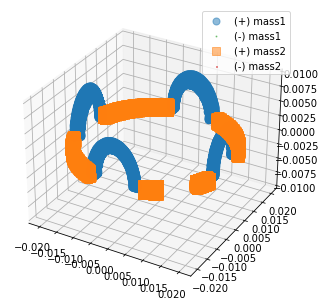

In [288]:
#trying to create frustrum thing
mass_distrib = get_frust(tf1 = testf1, tf2 = testf2, tf3 = testf3)
fig, ax = glb.display_points(mass_distrib[0], mass_distrib[1])
ax.set_zlim([-.01, .01])

In [198]:
hp = 0.00161036*0.00680974/(0.00680974-0.00523494)
vol = np.pi/2*(hp*0.00680974**2/3-0.00161036*0.00523494**2-(hp-0.00161036)*0.00523494**2/3)
vol

2.294463696113691e-08

In [281]:
vol2 = (0.02163572**2-.0200279**2)*0.001651*np.pi/7/2
print(vol2)
vol3 = (0.02163572**2-.0200279**2)*0.001651*np.pi/30/2
print(vol3)

2.481780331745883e-08
5.790820774073727e-09


In [289]:
totalvol = 4*vol+4*vol2+2*vol3
mpercent1 = .928/1000*vol/totalvol #0.00010508056905373423
mpercent2 = .928/1000*vol2/totalvol #0.00011365919189217833
mpercent3 = .928/1000*vol3/totalvol #2.652047810817494e-05
print(mpercent1, mpercent2, mpercent3)

0.00010508056905373423 0.00011365919189217833 2.652047810817494e-05


In [299]:
frust = rotate_trans(gshp.outer_cone(mpercent1, 0.00523494, 0.00680974, 0.00161036, np.pi/2, 50, 40))
frust = rotate_trans(frust, rotation = -np.pi/2, axis = [0, 1, 0])
frust = rotate_trans(frust, translation = [0.0200279, 0, 0])
f1 = rotate_trans(frust, rotation = np.pi/2)
f2 = rotate_trans(frust, rotation = np.pi)
f3 = rotate_trans(frust, rotation = 3*np.pi/2)
ftot = np.concatenate([frust, f1, f2, f3])
#-------------------------------------------------------------------------------------
enc = gshp.wedge(mpercent2, 0.0200279, 0.02163572, 0.001651, np.pi/7, 50, 10)
enc = rotate_trans(enc, rotation = np.pi/4)
enc1 = rotate_trans(enc, rotation = np.pi/2)
enc2 = rotate_trans(enc1, rotation = np.pi/2)
enclast1 = gshp.wedge(mpercent3, 0.0200279, 0.02163572, 0.001651, np.pi/30, 50, 10)
enclast1 = rotate_trans(enclast1, -np.pi/4+np.pi/10)
enclast2 = rotate_trans(enclast1, -2*np.pi/10)
enctot = np.concatenate([enc, enc1, enc2, enclast1, enclast2])
#ftot = rotate_trans(ftot, rotation = np.pi/4)
#enctot = rotate_trans(enctot, rotation = np.pi/4)
sinpart = rotate_trans(np.concatenate([ftot, enctot]), np.pi/4)

In [320]:
bar = gshp.rectangle(thick*thick*inner-0.02163572, thick, inner-0.02163572, thick, 20, 20, 20)
bar1 = rotate_trans(bar, translation = [0, (inner-0.02163572)/2+0.02163572, 0])
bar2 = rotate_trans(bar1, rotation = np.pi)
bartot = np.concatenate([bar1, bar2])

(-0.01, 0.01)

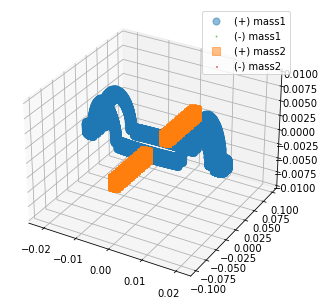

In [321]:
fig, ax = glb.display_points(sinpart, bartot)
ax.set_zlim([-.01, .01])

In [81]:
#creates middle "sinusoidal" section, cut out section points OOP & "rightward"
frust = rotate_trans(gshp.outer_cone(mpercent1, 0.00523494, 0.00680974, 0.00161036, np.pi/2, 50, 40))
frust = rotate_trans(frust, rotation = -np.pi/2, axis = [0, 1, 0])
frust = rotate_trans(frust, translation = [0.0200279, 0, 0])
f1 = rotate_trans(frust, rotation = np.pi/2)
f2 = rotate_trans(frust, rotation = np.pi)
f3 = rotate_trans(frust, rotation = 3*np.pi/2)
ftot = np.concatenate([frust, f1, f2, f3])
#-------------------------------------------------------------------------------------
enc = gshp.wedge(mpercent2, 0.0200279, 0.02163572, 0.001651, np.pi/7, 50, 10)
enc = rotate_trans(enc, rotation = np.pi/4)
enc1 = rotate_trans(enc, rotation = np.pi/2)
enc2 = rotate_trans(enc1, rotation = np.pi/2)
enclast1 = gshp.wedge(mpercent3, 0.0200279, 0.02163572, 0.001651, np.pi/30, 50, 10)
enclast1 = rotate_trans(enclast1, -np.pi/4+np.pi/10)
enclast2 = rotate_trans(enclast1, -2*np.pi/10)
enctot = np.concatenate([enc, enc1, enc2, enclast1, enclast2])
sintot = rotate_trans(np.concatenate([ftot, enctot]), np.pi/4)
#creates bar joining sinusoid to beams
bar = gshp.rectangle(THICK*THICK*(INNER_RAD-0.02163572), THICK, INNER_RAD-0.02163572, THICK, 20, 20, 20)
bar1 = rotate_trans(bar, translation = [0, (INNER_RAD-0.02163572)/2+0.02163572, 0])
bar2 = rotate_trans(bar1, rotation = np.pi)
bartot = np.concatenate([bar1, bar2])

(-0.01, 0.01)

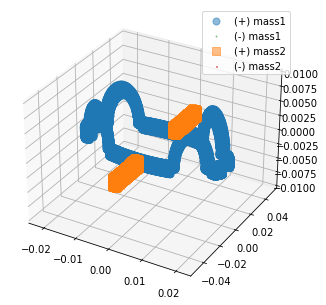

In [82]:
fig, ax = glb.display_points(sintot, bartot)
ax.set_zlim([-.01, .01])

In [83]:
testmass = np.concatenate([sintot, bartot])
testmoments = get_moments(testmass)
print_moments(testmass)

0.9189244127163106 mass [g]
(-4.085671868346985e-07+0j) 20 moment
(1.7106294166906256e-23-9.671661889950308e-24j) 21 moment
(-3.7973904039969766e-08+3.883039261065925e-23j) 22 moment


In [125]:
cylmass = gshp.wedge(1, 0, INCH, 3.85*INCH, np.pi, 40, 20)
cylmass1 = rotate_trans(cylmass, translation = [INCH, 0, 3.85*INCH/2+INCH*.85/2])
cylmass2 = rotate_trans(cylmass, translation = [-INCH, 0, 3.85*INCH/2+INCH*.85/2])
basecyl = gshp.wedge(2, 0, INCH*2, INCH*.85, np.pi, 40, 20)
testmasses = np.concatenate([cylmass1, cylmass2, basecyl])
leftside = rotate_trans(testmasses, translation = [INCH*4.5, 0, 0])
rightside = rotate_trans(testmasses, translation = [-INCH*4.5, 0, 0])
totaltestmass = np.concatenate([leftside, rightside])
totaltestmass = rotate_trans(totaltestmass, translation = [0, 0, INCH*.275/2])
baserect = gshp.rectangle(1, INCH*13, 2*INCH, INCH*.275, 50, 20, 10)
baserect = rotate_trans(baserect, translation = [0, 1.5*INCH, 0])
totalrotator = np.concatenate([baserect, totaltestmass])

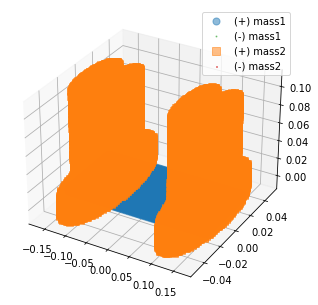

In [124]:
fig, ax = glb.display_points(baserect, totaltestmass)

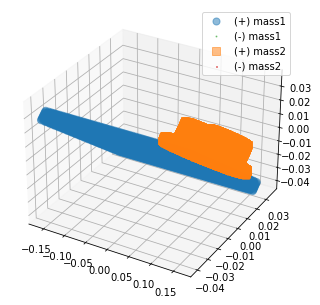

In [112]:
leftside = rotate_trans(leftside, rotation = -np.pi/4, axis = [1, 0, 0])
baserect = rotate_trans(baserect, rotation = -np.pi/4, axis = [1, 0, 0])
fig, ax = glb.display_points(baserect, leftside)

In [100]:
cylin = gshp.wedge(1, 0, 1, 1, np.pi, 60, 20)
rectang = gshp.rectangle(1, 1, 1, 1, 20, 20, 20)
cylin = rotate_trans(cylin, translation = [0, 0, 1])
cylin = rotate_trans(cylin, rotation = -np.pi/4, axis = [1, 0, 0])
rectang = rotate_trans(rectang, rotation = -np.pi/4, axis = [1, 0, 0])

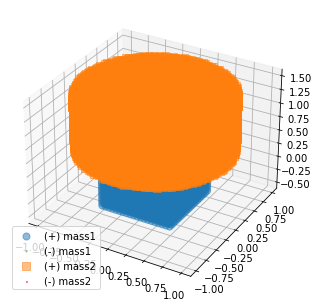

In [47]:
fig, ax = glb.display_points(rectang, cylin)

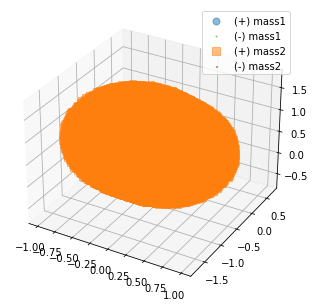

In [45]:
fig, ax = glb.display_points(rectang, cylin)

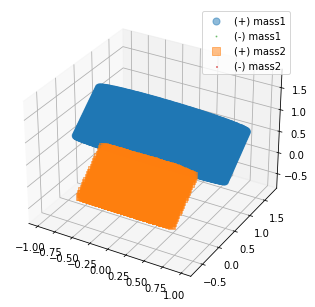

In [49]:
fig, ax = glb.display_points(cylin, rectang)